# 아이디어 정리



1. 데이터가 불균형하다. 해결할 수 있는 방법은? → Augmentation / Focal loss / 앙상블 관련 논문 https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-022-01821-w / label smoothing / 언더샘플링

## data Augmentation
Subject entity랑 Object entity를 바꾼 데이터도 추가해서 증강?

## Preprocess

1. Typed entity marker 추가
https://arxiv.org/pdf/2102.01373v4.pdf
2. train/test 데이터에 모두 source feature가 있다. 이를 토큰으로 넣어서 활용해도 도움이 될까?

# 데이터 Load

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 100
pd.options.display.max_columns = 30

In [7]:
train_df = pd.read_csv("../data/raw_data/train.csv")
test_df = pd.read_csv("../data/raw_data/test_data.csv")

In [8]:
train_df.head(3)

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree


In [10]:
test_df.head(3)

,id,sentence,subject_entity,object_entity,label,source
0,0,지난 15일 MBC '탐사기획 스트레이트'가 이 사실을 보도했다.,"{'word': 'MBC', 'start_idx': 7, 'end_idx': 9, ...","{'word': '탐사기획 스트레이트', 'start_idx': 12, 'end_i...",100,wikitree
1,1,사랑스러운 ‘프린세스 프링’의 이름은 봄의 공주님: Princess(s)Pring이...,"{'word': '프린세스 프링', 'start_idx': 7, 'end_idx':...","{'word': '공주', 'start_idx': 84, 'end_idx': 85,...",100,wikipedia
2,2,"한편, 본인(이근안)을 모델로 한 MBC 특집드라마 가 1995년 6.25 특집극으...","{'word': '경찰', 'start_idx': 121, 'end_idx': 12...","{'word': '1995년', 'start_idx': 31, 'end_idx': ...",100,wikipedia


In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32470 entries, 0 to 32469
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              32470 non-null  int64 
 1   sentence        32470 non-null  object
 2   subject_entity  32470 non-null  object
 3   object_entity   32470 non-null  object
 4   label           32470 non-null  object
 5   source          32470 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.5+ MB


# 중복 데이터 확인

93개의 중복 문장이 존재

In [23]:
train_df_is_duplicated = train_df.duplicated(subset=["sentence", "subject_entity", "object_entity"], keep=False)
df_duplicated = train_df.loc[train_df_is_duplicated, :]

In [27]:
len(df_duplicated)

93

In [ ]:
df_duplicated.sort_values(by=["sentence"])

중복 데이터 삭제

In [106]:
train_df_drop_duplicated = train_df.drop_duplicates(subset=["sentence", "subject_entity", "object_entity"]).reset_index(drop=True)

In [38]:
print("학습 데이터: ", len(train_df))
print("중복 제거 후 학습 데이터: ", len(train_df_drop_duplicated))
print("중복 제거된 데이터 개수: ", len(train_df) - len(train_df_drop_duplicated))

학습 데이터:  32470
중복 제거 후 학습 데이터:  32423
중복 제거된 데이터 개수:  47


# Sentence 문장 길이 확인

학습 문장 최대 길이:  455
학습 문장 평균 길이:  97.08885667581654


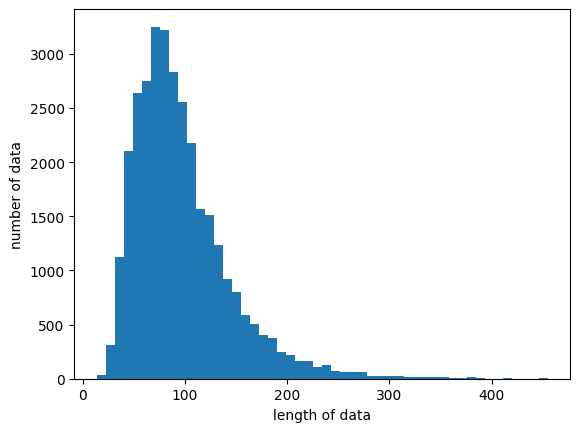

In [43]:
print("학습 문장 최대 길이: ", max(len(sent) for sent in train_df_drop_duplicated["sentence"]))
print("학습 문장 평균 길이: ", sum(map(len, train_df_drop_duplicated["sentence"])) / len(train_df_drop_duplicated["sentence"]))

plt.hist([len(s) for s in train_df_drop_duplicated["sentence"]], bins=50)
plt.xlabel("length of data")
plt.ylabel("number of data")
plt.show()

# label 분포

데이터 불균형

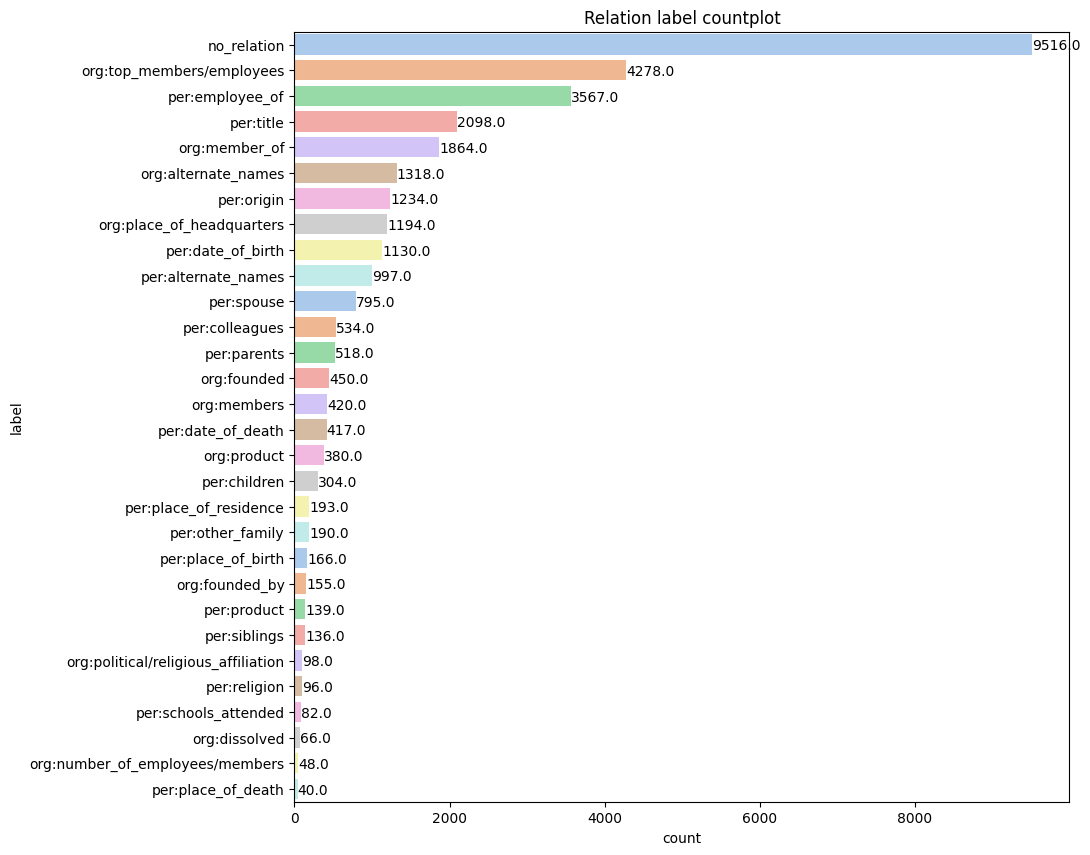

In [61]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax = sns.countplot(y='label', data=train_df_drop_duplicated, palette = sns.color_palette("pastel"), 
                    order = train_df_drop_duplicated['label'].value_counts().index, ax=ax)
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_x() + p.get_width(), p.get_y() + 0.6), fontsize=10)
plt.title("Relation label countplot")
plt.show()

# Source 종류와 분포

train/test 데이터에 모두 source feature가 있다. 이를 토큰으로 넣어서 활용해도 도움이 될까?

In [67]:
train_df_drop_duplicated["source"].value_counts()

wikipedia          21602
wikitree           10646
policy_briefing      175
Name: source, dtype: int64

wikipedia에는 어떤 label들이 많을까?

In [70]:
train_wikipedia = train_df_drop_duplicated[train_df_drop_duplicated["source"]=="wikipedia"]
train_wikitree = train_df_drop_duplicated[train_df_drop_duplicated["source"]=="wikitree"]
train_policy = train_df_drop_duplicated[train_df_drop_duplicated["source"]=="policy_briefing"]

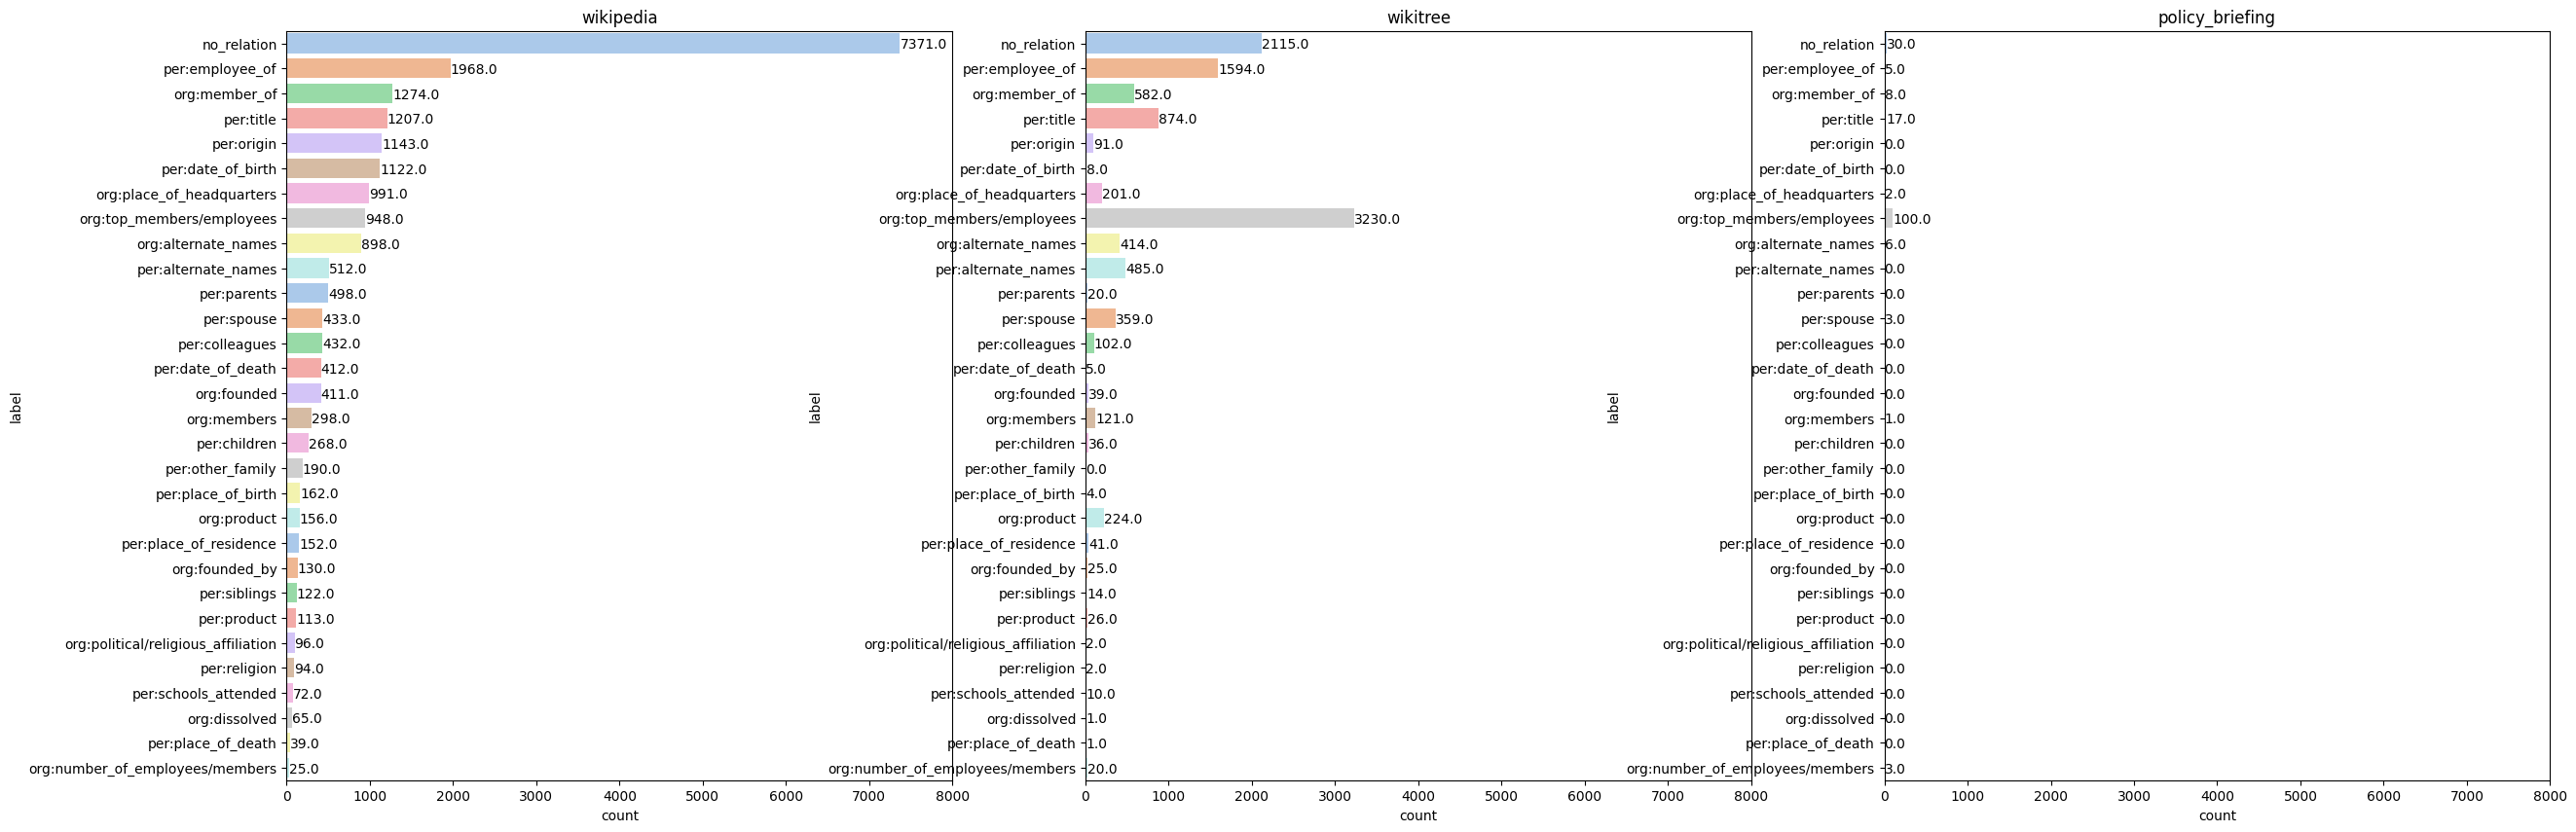

In [89]:
fig, axes = plt.subplots(1,3, figsize=(30,10))
sns.countplot(y='label', data=train_wikipedia, palette = sns.color_palette("pastel"), 
                    order = train_wikipedia['label'].value_counts().index, ax=axes[0])
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_width()}', (p.get_x() + p.get_width(), p.get_y() + 0.6), fontsize=10)
axes[0].set_title("wikipedia")
axes[0].set_xlim(0, 8000)

sns.countplot(y='label', data=train_wikitree, palette = sns.color_palette("pastel"), 
                    order = train_wikipedia['label'].value_counts().index, ax=axes[1])
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_width()}', (p.get_x() + p.get_width(), p.get_y() + 0.6), fontsize=10)
axes[1].set_title("wikitree")
axes[1].set_xlim(0, 8000)

sns.countplot(y='label', data=train_policy, palette = sns.color_palette("pastel"), 
                    order = train_wikipedia['label'].value_counts().index, ax=axes[2])
for p in axes[2].patches:
    axes[2].annotate(f'{p.get_width()}', (p.get_x() + p.get_width(), p.get_y() + 0.6), fontsize=10)
axes[2].set_title("policy_briefing")
axes[2].set_xlim(0, 8000)

plt.show()

# Entity type 분포 확인

Typed entity marker를 추가
https://arxiv.org/pdf/2102.01373v4.pdf

In [112]:
train_df_drop_duplicated.head(2)

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree


In [113]:
train_df_drop_duplicated.iloc[0]["subject_entity"]

"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26, 'type': 'ORG'}"

문장 : 그는 레오나르도 "다빈치 (Leonardo Da Vinci)" 처럼 공학 <br/>
subject_entity : "word" : '레오나르도 "다빈치' <br/>


이런 경우는??
→ 데이터 중에 괄호 부분 찾아봐야할 듯

In [119]:
train_df_drop_duplicated.iloc[17024]

id                                                            17035
sentence          그는 레오나르도 "다빈치 (Leonardo Da Vinci)" 처럼 공학, 과학 및...
subject_entity    {'word': '레오나르도 "다빈치', 'start_idx': 3, 'end_id...
object_entity     {'word': 'Leonardo Da Vinci', 'start_idx': 15,...
label                                           per:alternate_names
source                                                    wikipedia
Name: 17024, dtype: object

In [121]:
from ast import literal_eval

word, start_idx, end_idx, type = [], [], [], []

for sent in train_df_drop_duplicated["subject_entity"]:
    sent = literal_eval(sent)

    word.append(sent["word"])
    start_idx.append(sent["start_idx"])
    end_idx.append(sent["end_idx"])
    type.append(sent["type"])

train_df_drop_duplicated.loc[:,"subject_entity_word"] = word
train_df_drop_duplicated.loc[:,"subject_entity_start_idx"] = start_idx
train_df_drop_duplicated.loc[:,"subject_entity_end_idx"] = end_idx
train_df_drop_duplicated.loc[:,"subject_entity_type"] = type

In [127]:
word, start_idx, end_idx, type = [], [], [], []

for sent in train_df_drop_duplicated["object_entity"]:
    sent = literal_eval(sent)

    word.append(sent["word"])
    start_idx.append(sent["start_idx"])
    end_idx.append(sent["end_idx"])
    type.append(sent["type"])

train_df_drop_duplicated.loc[:,"object_entity_word"] = word
train_df_drop_duplicated.loc[:,"object_entity_start_idx"] = start_idx
train_df_drop_duplicated.loc[:,"object_entity_end_idx"] = end_idx
train_df_drop_duplicated.loc[:,"object_entity_type"] = type

In [128]:
train_df_drop_duplicated.head(2)

,id,sentence,subject_entity,object_entity,label,source,subject_entity_word,subject_entity_start_idx,subject_entity_end_idx,subject_entity_type,object_entity_word,object_entity_start_idx,object_entity_end_idx,object_entity_type
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia,비틀즈,24,26,ORG,조지 해리슨,13,18,PER
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree,민주평화당,19,23,ORG,대안신당,14,17,ORG


Object랑 Subject 위치를 바꿔서 데이터를 증강시키는 것은 어떨까

In [132]:
train_df_drop_duplicated["subject_entity_type"].value_counts()

PER    16760
ORG    15663
Name: subject_entity_type, dtype: int64

In [133]:
train_df_drop_duplicated["object_entity_type"].value_counts()

PER    9771
ORG    9331
POH    5102
DAT    4248
LOC    3559
NOH     412
Name: object_entity_type, dtype: int64

POH : 직업 <br/>
NOH : 수량